<a href="https://colab.research.google.com/github/ajinkyapatankar/Airbnb-Price-Prediction-System/blob/master/Capstone_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import pandas as pd
import numpy as np

In [0]:

link_listings = 'https://drive.google.com/open?id=1dEoEnfqhUWYTt5U9S7sKAfOuB8UUgybG'
link_reviews = 'https://drive.google.com/open?id=1-mBDclerkgdMhOldEJPMHWiZ8ZCsNWRy'

In [3]:
fluff, id = link_listings.split('=')
print (id) # Verify that you have everything after '='

1dEoEnfqhUWYTt5U9S7sKAfOuB8UUgybG


Reading the Listings.csv File

In [4]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('listings.csv')  
listings = pd.read_csv('listings.csv')
listings.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3647,https://www.airbnb.com/rooms/3647,20190912153101,2019-09-13,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",t,t,"New York, NY, United States",Harlem,Harlem,...,$20.00,3,7,3,3,7,7,3.0,7.0,37 months ago,t,30,60,90,365,2019-09-13,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
1,3831,https://www.airbnb.com/rooms/3831,20190912153101,2019-09-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,92%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Brooklyn, NY, United States",Brooklyn,Clinton Hill,...,$0.00,1,730,1,1,730,730,1.0,730.0,3 days ago,t,1,3,8,192,2019-09-13,279,67,2014-09-30,2019-08-29,90.0,9.0,9.0,10.0,9.0,10.0,9.0,f,NaN,NaN,f,f,moderate,f,f,1,1,0,0,4.62
2,5022,https://www.airbnb.com/rooms/5022,20190912153101,2019-09-13,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,NaN,NaN,NaN,NaN,Please be considerate when staying in the apar...,NaN,NaN,https://a0.muscache.com/im/pictures/feb453bd-f...,NaN,7192,https://www.airbnb.com/users/show/7192,Laura,2009-01-29,"Miami, Florida, United States",I have been a NYer for almost 10 years. I came...,NaN,NaN,NaN,f,https:/

In [5]:
fluff, id = link_reviews.split('=')
print (id) # Verify that you have everything after '='

1-mBDclerkgdMhOldEJPMHWiZ8ZCsNWRy


Reading the reviews.csv file

In [6]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('reviews.csv')  
reviews = pd.read_csv('reviews.csv')
reviews.loc[reviews['listing_id'] == 3831]

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3831,20509269,2014-09-30,20417598,Courtney,"lisa is a wonderful, kind and thoughtful host...."
1,3831,22232975,2014-11-02,6050386,Monica,The best thing about this place is the locatio...
2,3831,22550887,2014-11-09,15051380,Lynette,LisaRoxanne was friendly and helpful. The room...
3,3831,22984049,2014-11-19,7279245,Linnea,LisaRoxanne is very nice and communicative. Th...
4,3831,23604706,2014-12-06,16310850,Benjamin,Lisa was a very pleasant and nice host that ac...
...,...,...,...,...,...,...
274,3831,499514908,2019-07-31,9118490,Frédéric,Thank you for our stay Lisa Roxanne and your w...
275,3831,510816688,2019-08-16,9384571,Dena,We decided not stay for the 5 nights we reserv...
276,3831,517473803,2019-08-25,113239672,Savannah,This space was perfect for my husband and I to...
277,3831,518361546,2019-08-26,276123109,Rajkumar,Nice place in Brooklyn for stay


Dropping all the irrelavent columns

In [0]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 
                'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 
                'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 
                'host_neighbourhood', 'host_verifications', 'calendar_last_scraped','experiences_offered',
                'host_acceptance_rate','street','city','state','zipcode','country_code','country',
                'is_location_exact','license','jurisdiction_names','is_business_travel_ready','square_feet',
               'weekly_price','monthly_price','last_review','first_review','maximum_nights_avg_ntm','minimum_nights_avg_ntm',
                'maximum_maximum_nights','minimum_maximum_nights','maximum_minimum_nights','minimum_minimum_nights','host_has_profile_pic',
                'has_availability','require_guest_profile_picture', 'require_guest_phone_verification','requires_license','host_total_listings_count', 
                'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']
listings = listings.drop(cols_to_drop, axis=1)


Calculating the no. of Days from the date column of Host_Since

In [8]:
df=listings
from datetime import datetime
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1420.0
Median days as host: 1424.0


In [9]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.394712
unknown               0.339335
within a few hours    0.153441
within a day          0.093950
a few days or more    0.018563
Name: host_response_time, dtype: float64

One Hot Encoding for the amenities

In [0]:
l=[[word.strip('[" ]') for word in row[1:-1].split(',')] for row in list(df['amenities'])]
#for demonstration, reducing data to 100 rows
l=l[:100]#remove this line to include whole data
cols=set(word for row in l  for word in row)

In [11]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Game console'), 'Game console'] = 1
df.loc[df['amenities'].str.contains('BBQ grill'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV|Cable TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics|Kitchen|Refrigirator|Stove|Oven|Dishwasher|Dishes|silverware'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Carbon monoxide detector|Smoke detector|Fire extinguisher'), 'Smoked_detection'] = 1
df.loc[df['amenities'].str.contains('parking|Parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Hair dryer|shampoo'), 'Bathroom_amenities'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children|Changing table|child_friendly|Baby|crib|High chair'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('Dryer|Washer|Washer/Dryer'),'Laundry'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Garden|Backyard'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi|Ethernet connection'),'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)|Pets live on this property'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safety card|Keypad|Smart lock|Lock|Buzzer'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1
df.loc[df['amenities'].str.contains('Pool'), 'pool'] = 1
df.loc[df['amenities'].str.contains('Heating'), 'Heating'] = 1
df.loc[df['amenities'].str.contains('Falt path to guest entrance|Wheelchair|No staris or steps|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Well-lit path to entrance'), 'well_lit_entrance'] = 1
df.loc[df['amenities'].str.contains('Essentials'), 'essentials'] = 1
df.loc[df['amenities'].str.contains('Indoor fireplace'), 'indoor_fireplace'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [0]:
#df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi|'), 'internet'] = 1
#df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
list_amm = list(df.columns[47:])

In [0]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [0]:
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [0]:
bin_column('review_scores_value',
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')


Host Response Rate

In [16]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 16416
Proportion: 33.9%


In [17]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")


Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 65.6%


In [18]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       20961
unknown    16416
50-89%      5582
90-99%      4033
0-49%       1385
Name: host_response_rate, dtype: int64

In [0]:
df[df.columns[47:]] = df[df.columns[47:]].fillna(value=0)
df_zero_new_amm=df.copy()

In [0]:
# df

Dropping the amenities which are skewd

In [0]:
col_name = ['Game console','bbq','nature_and_views','internet','smoking_allowed','pool','event_suitable','indoor_fireplace']
df_zero_new_amm = df_zero_new_amm.drop(columns = col_name,axis = 1)
df_new_final = df_zero_new_amm  
 

Converting the string attrs into int

In [0]:
df_new_final.price = df_new_final.price.str[1:-3]
df_new_final.price = df_new_final.price.str.replace(",", "")
df_new_final.price = df_new_final.price.astype('int64')

In [0]:
df_new_final.security_deposit = df_new_final.security_deposit.str[1:-3]
df_new_final.security_deposit = df_new_final.security_deposit.str.replace(",", "")
df_new_final.security_deposit.fillna(0, inplace=True)

In [0]:
df_new_final.cleaning_fee = df_new_final.cleaning_fee.str[1:-3]
df_new_final.cleaning_fee = df_new_final.cleaning_fee.str.replace(",", "")
df_new_final.cleaning_fee.fillna(0, inplace=True)


In [0]:
df_new_final.extra_people = df_new_final.extra_people.str[1:-3]
df_new_final.extra_people = df_new_final.extra_people.str.replace(",", "")
df_new_final.extra_people = df_new_final.extra_people.astype('int64')

In [0]:
#df_new_final.host_response_rate = df_new_final.host_response_rate.str[0:-1]
#df_new_final.host_response_rate = df_new_final.host_response_rate.str.replace('','0')

#df_new_final.host_response_rate.fillna(0, inplace=True)
# df_new_final['host_response_rate'] = df_new_final['host_response_rate'].astype(int)
#df_new_final.host_response_rate = df_new_final.host_response_rate.astype('int64')
 

In [0]:
col = ['beds','bathrooms', 'bedrooms']
for c in col:
  df_new_final[c].fillna(df_new_final[c].median(),inplace = True)

In [0]:
df_new_final.drop('bed_type', axis=1, inplace=True)
df_new_final.drop('calendar_updated', axis=1, inplace=True)
df_new_final.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)
df_new_final.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

Binnig the property type

In [0]:
df_new_final.property_type.replace({
    'Townhouse': 'House',
    'Condominium': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Aparthotel': 'Apartment',
    'Guest suite': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House' 
    }, inplace=True)

# Replacing other categories with 'other'
df_new_final.loc[~df_new_final.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'


In [0]:
# df[['availability_30','availability_60','availability_90','availability_365']]
# df.columns
df_new_final.drop(['availability_30','availability_60','availability_90'], axis=1, inplace=True)

In [0]:
df_new_final.drop([ 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location'], axis=1, inplace=True)

In [0]:
df_new_final.host_identity_verified = df_new_final['host_identity_verified'].replace('f',0)
df_new_final.host_identity_verified = df_new_final['host_identity_verified'].replace('t',1)
df_new_final.host_is_superhost = df_new_final['host_is_superhost'].replace('f',0)
df_new_final.host_is_superhost = df_new_final['host_is_superhost'].replace('t',1)

In [32]:
df_new_final.host_identity_verified.value_counts()

0.0    25331
1.0    23025
Name: host_identity_verified, dtype: int64

In [0]:
df_new_final['security_deposit'] = df_new_final['security_deposit'].astype(int)

In [0]:
df_new_final['cleaning_fee'] = df_new_final['cleaning_fee'].astype(int)

In [0]:
df_new_final.drop('amenities',axis=1,inplace=True)

Removed columns whose more than 80% values are null

In [0]:
feature_removal_df = df_new_final.loc[:, df_new_final.isnull().mean() < .8]

In [37]:
len(feature_removal_df.columns)

60

In [0]:
#feature_df = df_new_final[['id', 'host_since','host_response_time','host_response_rate',
#       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
 #      'neighbourhood', 'neighbourhood_cleansed',
  #     'neighbourhood_group_cleansed', 'market', 'smart_location', 
   #    'property_type', 'room_type', 'accommodates', 'bathrooms',
    #   'bedrooms', 'beds', 'security_deposit',
#       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
 #      'maximum_nights', 'availability_365', 'number_of_reviews',
  #     'review_scores_rating', 'review_scores_value', 'instant_bookable',
   #    'cancellation_policy', 'host_days_active', 'check_in_24h',
    #   'air_conditioning', 'balcony', 'bed_linen', 'breakfast', 'tv',
#       'coffee_machine', 'cooking_basics', 'Smoked_detection', 'parking',
 #      'Bathroom_amenities', 'child_friendly', 'Laundry', 'elevator', 'gym',
  #     'outdoor_space', 'host_greeting', 'long_term_stays', 'pets_allowed',
   #    'private_entrance', 'secure', 'self_check_in', 'Heating', 'accessible',
    #   'well_lit_entrance', 'essentials']]
  

In [0]:
feature_df = df_new_final.copy()

In [39]:
feature_df.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'market', 'smart_location', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'host_days_active', 'check_in_24h', 'air_conditioning', 'balcony',
       'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics',
       'Smoked_detection', 'parking', 'Bathroom_amenities', 'child_friendly',
       'Laundry', 'elevator', 'gym', 'outdoor_space', 'host_greeting',
       'long_term_stays', 'pets_allowed', 'private_

In [40]:
target_df = df_new_final[['price']]
target_df

,price
0,150
1,89
2,80
3,200
4,60
...,...
48372,199
48373,175
48374,35
48375,79


In [0]:
column = ["neighbourhood","smart_location","neighbourhood_cleansed","host_since"]

In [0]:
feature_df = feature_df.drop(columns = column, axis = 1)

In [0]:
feature_df = feature_df.drop(columns = "market", axis = 1)

In [44]:
feature_df['review_scores_value'].value_counts()

10/10     21048
9/10      12921
nan       10618
0-8/10     3790
Name: review_scores_value, dtype: int64

One hot encoding for categorical attributes


In [0]:
transformed_df = pd.get_dummies(feature_df)

In [0]:
# transformed_df.columns

In [0]:
# transformed_df.shape

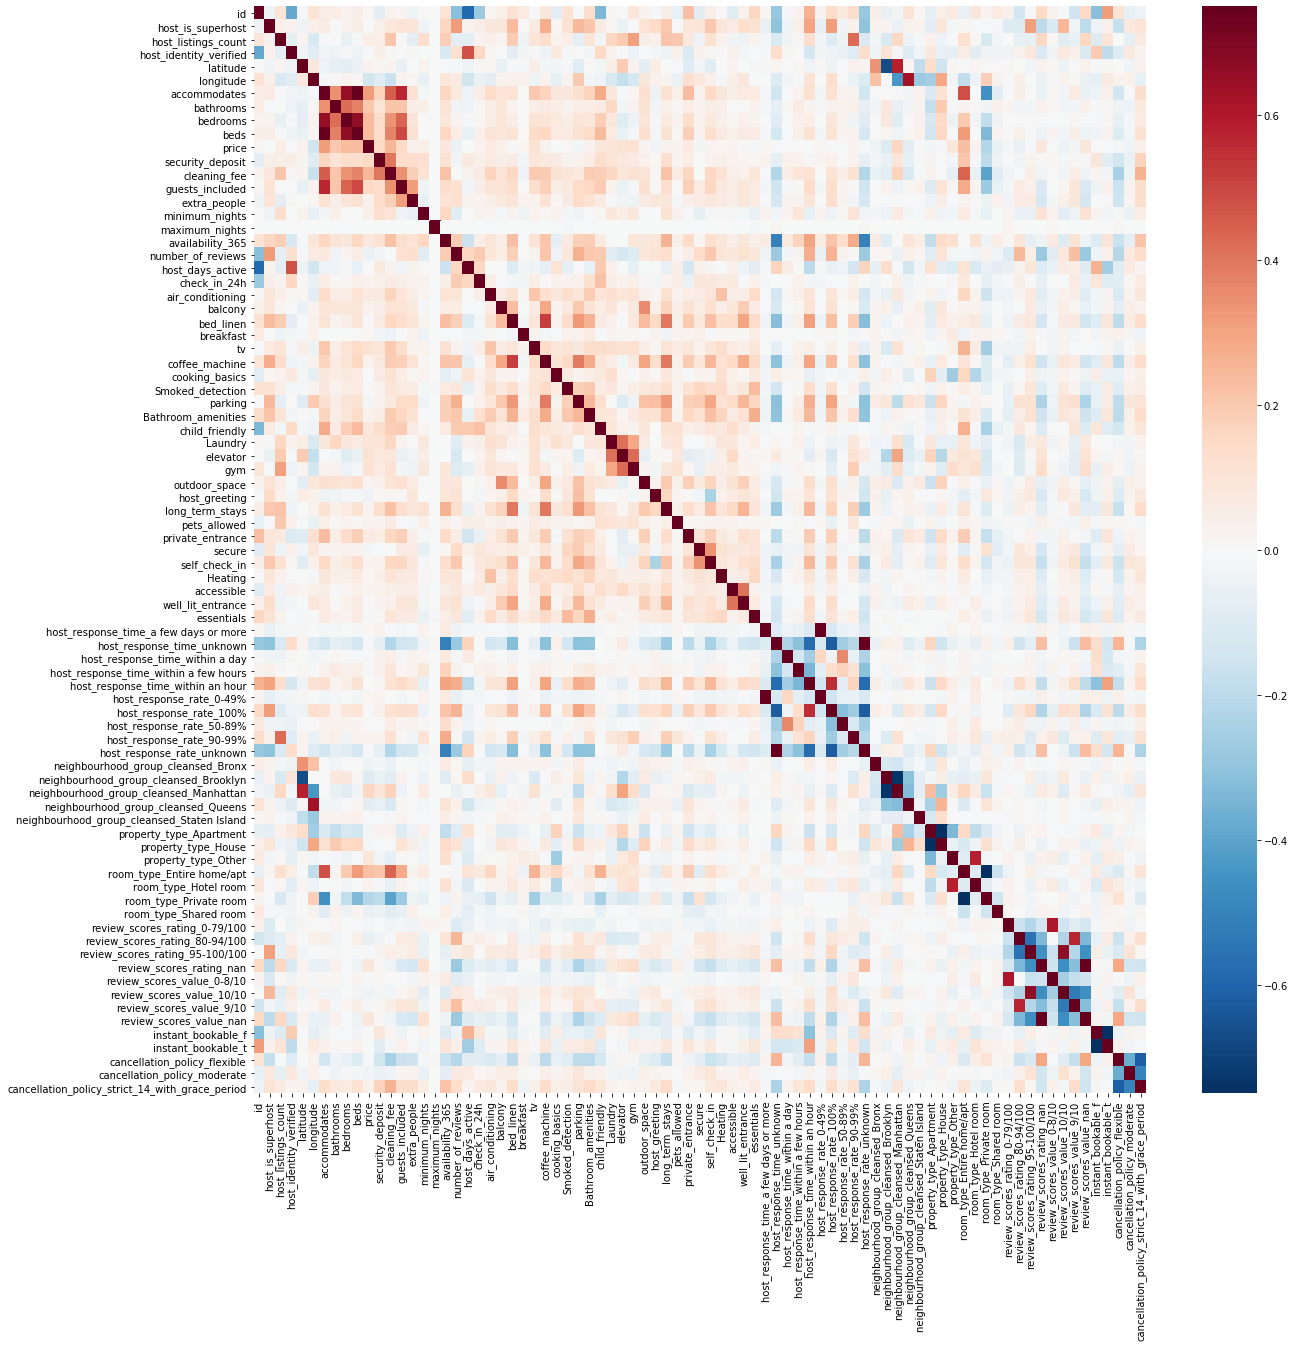

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation = transformed_df.corr()
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(correlation, annot=False, linewidths=0, vmin=-0.75, vmax=0.75, cmap="RdBu_r")

In [0]:
correlated_features = set()
correlation_matrix = transformed_df.drop('price', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [0]:
# correlated_features

In [0]:
# Dropping collinear features
to_drop=[]
# to_drop = ['beds',
#            'bedrooms',
#            'guests_included', 
#            'host_response_rate_unknown',
#            'host_response_rate_0-49%',
#            'host_response_time_unknown',
#            'property_type_Apartment',
#            'room_type_Private room'] 
# to_drop.extend(['latitude','longitude','beds','coffee_machine'])
# to_drop.extend(list(correlated_features))
# to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)
saved_transformed_df=transformed_df.copy()

In [0]:
# saved_transformed_df=transformed_df.copy()

In [0]:
# transformed_df=saved_transformed_df.copy()

In [0]:
#transformed_df = transformed_df.drop('id', axis=1, inplace=True)
transformed_df=transformed_df[transformed_df['price'] < 500]

In [0]:
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression

In [0]:
X = transformed_df.drop(['price','id'],axis = 1)
y = transformed_df.price

In [0]:
# y=y.astype('float64').replace(0, 0.01)
# y=np.log(y)

In [0]:
X['host_listings_count'].fillna((X['host_listings_count'].median()), inplace=True)
X[['host_is_superhost','host_identity_verified']] = X[['host_is_superhost','host_identity_verified']].fillna(0)

In [59]:
lm = LinearRegression()

#X = transformed_df
#y = target_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# y_test

In [0]:
X.columns[X.isna().any()].tolist()
X.loc[:, X.isna().any()]

X['host_listings_count'].fillna((X['host_listings_count'].median()), inplace=True)

In [62]:
'''Get Predictions & Print Metrics'''
predicts = lm.predict(X_test)

print("""
        Root Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, predicts)),
        r2_score(y_test,predicts) * 100,
        mean_absolute_error(y_test,predicts)
        ))


        Root Mean Squared Error: 55.32608221829119
        R2 Score: 57.91173911020528
        Mean Absolute Error: 38.47123977815358
     


In [0]:
df_lmmodel = pd.DataFrame({'Linear Regression Predicted':predicts})

In [0]:
# df_mine

In [0]:
# from sklearn.svm import SVR
# regressor = SVR(kernel='rbf')
# regressor.fit(X_train,y_train)
# y_pred = regressor.predict(X_test)

In [0]:
# linear_predictions = pd.DataFrame({'Actual':y_test})
# linear_predictions = linear_predictions.reset_index(drop=True)
# linear_predictions

In [0]:
# df_log_Comparison = pd.DataFrame({'Actual':np.exp(linear_predictions['Actual']),'Initial Model Predicted':np.exp(df_lmmodel['Linear Regression Predicted'])})
# df_log_Comparison

In [0]:
# antilog_y_test=np.exp(y_test)
# antilog_predict=np.exp(predicts)
# print("""
#         Root Mean Squared Error: {}
#         R2 Score: {}
#         Mean Absolute Error: {}
#      """.format(
#         np.sqrt(metrics.mean_squared_error(antilog_y_test, antilog_predict)),
#         r2_score(antilog_y_test, antilog_predict) * 100,
#         mean_absolute_error(antilog_y_test, antilog_predict)
#         ))


        # Root Mean Squared Error: 57.05670832744262
        # R2 Score: 55.23747214044437
        # Mean Absolute Error: 37.24604003003832


Standadizing and normailizing

In [0]:
numerical_columns = ['accommodates', 'bathrooms', 'host_listings_count','cleaning_fee', 'extra_people', 'host_days_active', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

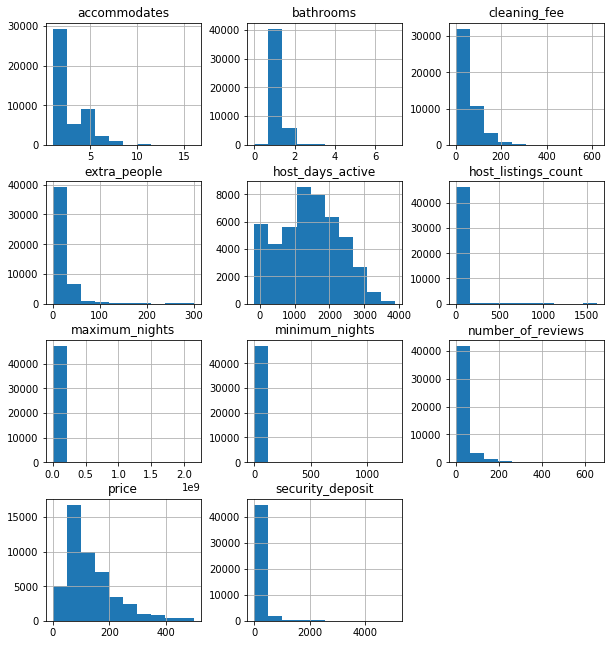

In [69]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [0]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [0]:
# transformed_df[numerical_columns].hist(figsize=(10,11));

In [0]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [0]:
# def ridge_reg(input_x, input_y, cv=5):
#     ## Defining parameters
#     model_Ridge= Ridge()

#     # prepare a range of alpha values to test
#     alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
#     normalizes= ([True,False])

#     ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

#     grid_search_Ridge = GridSearchCV(estimator=model_Ridge,  
#                          param_grid=(dict(alpha=alphas, normalize= normalizes)),
#                          scoring='neg_mean_squared_error',
#                          cv=cv,
#                          n_jobs=-1)

#     ## Lastly, finding the best parameters.

#     grid_search_Ridge.fit(input_x,input_y)
#     best_parameters_Ridge = grid_search_Ridge.best_params_  
#     best_score_Ridge = grid_search_Ridge.best_score_ 
#     print(best_parameters_Ridge)
#     print(best_score_Ridge)

# ridge_reg(X_train, y_train)


In [0]:
# ridge_x = Ridge(alpha = 0.01, normalize = True)
# ridge_x.fit(X_train, y_train)  
# pred_ridge = ridge_x.predict(X_test) 
# print('MAE: %f'% mean_absolute_error(y_test, pred_ridge))
# print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, pred_ridge)))   
# print('R2 %f' % r2_score(y_test, pred_ridge))


In [0]:
from sklearn.linear_model import Lasso

In [0]:
# def lasso_reg(input_x, input_y, cv=5):
#     ## Defining parameters
#     model_Lasso= Lasso()

#     # prepare a range of alpha values to test
#     alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
#     normalizes= ([True,False])

#     ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

#     grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
#                          param_grid=(dict(alpha=alphas, normalize= normalizes)),
#                          scoring='neg_mean_squared_error',
#                          cv=cv,
#                          n_jobs=-1)

#     ## Lastly, finding the best parameters.

#     grid_search_lasso.fit(input_x, input_y)
#     best_parameters_lasso = grid_search_lasso.best_params_  
#     best_score_lasso = grid_search_lasso.best_score_ 
#     print(best_parameters_lasso)
#     print(best_score_lasso)

# lasso_reg(X_train, y_train)

In [0]:
# Lasso_x = Lasso(alpha = 0.001, normalize =True)
# Lasso_x.fit(X_train, y_train)
# pred_Lasso = Lasso_x.predict(X_test) 
# print('MAE: %f' % mean_absolute_error(y_test, pred_Lasso))
# print('RMSE: %f' % np.sqrt(mean_squared_error(y_test, pred_Lasso)))
# print('R2 %f' % r2_score(y_test, pred_Lasso))

Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [0]:
# n_folds = 5
# def rmse_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(transformed_df)
#     return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

# def rmse_lv_cv(model):
#     kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(transformed_df)
#     return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [0]:
# rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
# rfr_baseline = RandomForestRegressor(random_state=42)
# rfr_baseline.fit(X_train, y_train) 
# y_train_rfr = rfr_baseline.predict(X_train)
# y_test_rfr = rfr_baseline.predict(X_test)
# rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
#             'CV error': rfr_CV_baseline.mean(), 
#             'CV std': rfr_CV_baseline.std(),
#             'training error': [mean_squared_error(y_train_rfr, y_train)],
#             'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [0]:
# RF_predictor = pd.DataFrame({'Random Forest Regressor Predictions':y_test_rfr})
# df_RF_Comparison = pd.DataFrame({'Actual':y_test,'Random Forest Regressor Predictions':y_test_rfr})
# df_RF_Comparison

random_state = 

In [80]:
feature_removal_df.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'market', 'smart_location', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'host_days_active', 'check_in_24h', 'air_conditioning', 'balcony',
       'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics',
       'Smoked_detection', 'parking', 'Bathroom_amenities', 'child_friendly',
       'Laundry', 'elevator', 'gym', 'outdoor_space', 'host_greeting',
       'long_term_stays', 'pets_allowed', 'private_

In [0]:
feature_removal_df
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
columns_new = ['id', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'smart_location',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'check_in_24h', 'air_conditioning', 'balcony',
       'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics',
       'Smoked_detection', 'parking', 'Bathroom_amenities', 'child_friendly',
       'Laundry', 'elevator', 'gym', 'outdoor_space', 'host_greeting',
       'long_term_stays', 'pets_allowed', 'private_entrance', 'secure',
       'self_check_in', 'Heating', 'accessible', 'well_lit_entrance',
       'essentials']
X = feature_removal_df[columns_new]  #independent columns
y = feature_removal_df['price']    #target column i.e price range


In [82]:
X

,id,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,smart_location,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_value,instant_bookable,cancellation_policy,check_in_24h,air_conditioning,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,Smoked_detection,parking,Bathroom_amenities,child_friendly,Laundry,elevator,gym,outdoor_space,host_greeting,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,Heating,accessible,well_lit_entrance,essentials
0,3647,0-49%,0.0,1.0,1.0,Harlem,Manhattan,"New York, NY",Apartment,Private room,2,1.0,1.0,1.0,200,75,2,20,3,7,365,0,nan,nan,f,strict_14_with_grace_period,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,3831,90-99%,0.0,1.0,1.0,Clinton Hill,Brooklyn,"Brooklyn, NY",Apartment,Entire home/apt,3,1.0,1.0,4.0,500,0,1,0,1,730,192,279,80-94/100,9/10,f,moderate,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,5022,unknown,0.0,1.0,1.0,East Harlem,Manhattan,"New York, NY",Apartment,Entire home/apt,1,1.0,1.0,1.0,100,80,1,20,10,120,0,9,80-94/100,10/10,f,strict_14_with_grace_period,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,5099,50-89%,0.0,1.0,0.0,Murray Hill,Manhattan,"New York, NY",Apartment,Entire home/apt,2,1.0,1.0,1.0,300,125,2,100,3,21,13,75,80-94/100,9/10,f,moderate,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5121,0-49%,0.0,1.0,0.0,Bedford-Stuyvesant,Brooklyn,"Brooklyn, NY",Apartment,Private room,2,1.0,1.0,1.0,450,0,1,30,45,730,0,49,80-94/100,9/10,f,strict_14_with_grace_period,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48372,38564068,100%,0.0,0.0,0.0,Cypress Hills,Brooklyn,"Brooklyn, NY",Apartment,Entire home/apt,7,2.0,3.0,4.0,100,100,4,50,2,10,42,0,nan,nan,f,strict_14_with_grace_period,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
48373,38564524,unknown,0.0,0.0,0.0,Upper East Side,Manhattan,"New York, NY",Apartment,Entire home/apt,2,1.0,0.0,1.0,5000,300,1,0,30,1125,263,0,nan,nan,t,moderate,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
48374,38566777,unknown,0.0,1.0,0.0,Bushwick,Brooklyn,"Brooklyn , NY",Apartment,Private room,1,1.0,1.0,1.0,0,0,1,0,30,1125,66,0,nan,nan,f,flexible,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
48375,38567542,100%,0.0,10.0,0.0,Crown Heights,Brooklyn,"Brooklyn, NY",House,Private room,4,3.0,1.0,1.0,0,39,1,15,1,365,322,0,nan,nan,f,strict_14_with_grace_period,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [83]:
y

0        150
1         89
2         80
3        200
4         60
        ... 
48372    199
48373    175
48374     35
48375     79
48376     45
Name: price, Length: 48377, dtype: int64

In [84]:
from sklearn.svm import SVR
svr_lin  = SVR(kernel='poly',C=1e3)
svr_lin.fit(X_train, y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
svr_predict = svr_lin.predict(X_test)

In [86]:
svr_predict

array([100.09997103, 100.09997103, 100.09997103, ..., 100.09997103,
       100.09997103, 100.09997103])

In [87]:
svr_p1=pd.DataFrame(svr_predict)
# svr_p1=svr_p1.astype('float64').replace(0,0.1)
# svr_p=np.exp(svr_p1)
# for a in svr_p1:
#   print(a)
svr_p1
  # print("""
#         Root Mean Squared Error: {}
#         R2 Score: {}
#         Mean Absolute Error: {}
#      """.format(
#         np.sqrt(metrics.mean_squared_error(y_test, svr_p)),
#         r2_score(y_test,  svr_p) * 100,
#         mean_absolute_error(y_test,  svr_p)
#         ))

,0
0,100.099971
1,100.099971
2,100.099971
3,100.099971
4,100.099971
...,...
9438,100.099971
9439,100.099971
9440,100.099971
9441,100.099971


In [88]:
from sklearn.preprocessing import LabelEncoder
gle = LabelEncoder()

host_response_rate_labels = gle.fit_transform(X['host_response_rate'])
host_response_rate_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(host_response_rate_mappings)
X[['host_response_rate']] = host_response_rate_labels

#neighbourhood_labels = gle.fit_transform(X['neighbourhood'])

neighbourhood_cleansed_labels = gle.fit_transform(X['neighbourhood_cleansed'])
neighbourhood_cleansed_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(neighbourhood_cleansed_mappings)
X[['neighbourhood_cleansed']] = neighbourhood_cleansed_labels

neighbourhood_group_cleansed_labels = gle.fit_transform(X['neighbourhood_group_cleansed'])
neighbourhood_group_cleansed_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(neighbourhood_group_cleansed_mappings)
X[['neighbourhood_group_cleansed']] = neighbourhood_cleansed_labels

#market_labels = gle.fit_transform(X['market'])

smart_location_labels = gle.fit_transform(X['smart_location'])
smart_location_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(smart_location_mappings)
X[['smart_location']] = smart_location_labels

property_type_labels = gle.fit_transform(X['property_type'])
property_type_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(property_type_mappings)
X[['property_type']] = property_type_labels

room_type_labels = gle.fit_transform(X['room_type'])
room_type_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(room_type_mappings)
X[['room_type']] = room_type_labels


review_scores_rating_labels = gle.fit_transform(X['review_scores_rating'])
review_scores_rating_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(review_scores_rating_mappings)
X[['review_scores_rating']] = review_scores_rating_labels


review_scores_value_labels = gle.fit_transform(X['review_scores_value'])
review_scores_value_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(review_scores_value_mappings)
X[['review_scores_value']] = review_scores_value_labels

instant_bookable_labels = gle.fit_transform(X['instant_bookable'])
instant_bookable_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(instant_bookable_mappings)
X[['instant_bookable']] = instant_bookable_labels

cancellation_policy_labels = gle.fit_transform(X['cancellation_policy'])
cancellation_policy_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
print(cancellation_policy_mappings)
X[['cancellation_policy']] = cancellation_policy_labels


{0: '0-49%', 1: '100%', 2: '50-89%', 3: '90-99%', 4: 'unknown'}
{0: 'Allerton', 1: 'Arden Heights', 2: 'Arrochar', 3: 'Arverne', 4: 'Astoria', 5: 'Bath Beach', 6: 'Battery Park City', 7: 'Bay Ridge', 8: 'Bay Terrace', 9: 'Bay Terrace, Staten Island', 10: 'Baychester', 11: 'Bayside', 12: 'Bayswater', 13: 'Bedford-Stuyvesant', 14: 'Belle Harbor', 15: 'Bellerose', 16: 'Belmont', 17: 'Bensonhurst', 18: 'Bergen Beach', 19: 'Boerum Hill', 20: 'Borough Park', 21: 'Breezy Point', 22: 'Briarwood', 23: 'Brighton Beach', 24: 'Bronxdale', 25: 'Brooklyn Heights', 26: 'Brownsville', 27: "Bull's Head", 28: 'Bushwick', 29: 'Cambria Heights', 30: 'Canarsie', 31: 'Carroll Gardens', 32: 'Castle Hill', 33: 'Castleton Corners', 34: 'Charleston', 35: 'Chelsea', 36: 'Chinatown', 37: 'City Island', 38: 'Civic Center', 39: 'Claremont Village', 40: 'Clason Point', 41: 'Clifton', 42: 'Clinton Hill', 43: 'Co-op City', 44: 'Cobble Hill', 45: 'College Point', 46: 'Columbia St', 47: 'Concord', 48: 'Concourse', 49: '

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [89]:
X['host_listings_count'].fillna((X['host_listings_count'].median()), inplace=True)
X[['host_is_superhost','host_identity_verified']] = X[['host_is_superhost','host_identity_verified']].fillna(0)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [90]:
X

,id,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,smart_location,property_type,room_type,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_value,instant_bookable,cancellation_policy,check_in_24h,air_conditioning,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,Smoked_detection,parking,Bathroom_amenities,child_friendly,Laundry,elevator,gym,outdoor_space,host_greeting,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,Heating,accessible,well_lit_entrance,essentials
0,3647,0,0.0,1.0,1.0,97,97,190,0,2,2,1.0,1.0,1.0,200,75,2,20,3,7,365,0,3,3,0,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,3831,3,0.0,1.0,1.0,42,42,57,0,0,3,1.0,1.0,4.0,500,0,1,0,1,730,192,279,1,2,0,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,5022,4,0.0,1.0,1.0,63,63,190,0,0,1,1.0,1.0,1.0,100,80,1,20,10,120,0,9,1,1,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,5099,2,0.0,1.0,0.0,140,140,190,0,0,2,1.0,1.0,1.0,300,125,2,100,3,21,13,75,1,2,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,5121,0,0.0,1.0,0.0,13,13,57,0,2,2,1.0,1.0,1.0,450,0,1,30,45,730,0,49,1,2,0,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48372,38564068,1,0.0,0.0,0.0,54,54,57,0,0,7,2.0,3.0,4.0,100,100,4,50,2,10,42,0,3,3,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
48373,38564524,4,0.0,0.0,0.0,204,204,190,0,0,2,1.0,0.0,1.0,5000,300,1,0,30,1125,263,0,3,3,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
48374,38566777,4,0.0,1.0,0.0,28,28,46,0,2,1,1.0,1.0,1.0,0,0,1,0,30,1125,66,0,3,3,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
48375,38567542,1,0.0,10.0,0.0,53,53,57,1,2,4,3.0,1.0,1.0,0,39,1,15,1,365,322,0,3,3,0,2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [91]:
#X.isna().sum()
(X < 0).any()

id                              False
host_response_rate              False
host_is_superhost               False
host_listings_count             False
host_identity_verified          False
neighbourhood_cleansed          False
neighbourhood_group_cleansed    False
smart_location                  False
property_type                   False
room_type                       False
accommodates                    False
bathrooms                       False
bedrooms                        False
beds                            False
security_deposit                False
cleaning_fee                    False
guests_included                 False
extra_people                    False
minimum_nights                  False
maximum_nights                  False
availability_365                False
number_of_reviews               False
review_scores_rating            False
review_scores_value             False
instant_bookable                False
cancellation_policy             False
check_in_24h

In [92]:
3#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                           Specs         Score
19                maximum_nights  1.624981e+11
0                             id  1.195665e+10
3            host_listings_count  8.654010e+06
14              security_deposit  5.103584e+06
15                  cleaning_fee  9.210927e+05
20              availability_365  4.060025e+05
18                minimum_nights  1.292611e+05
21             number_of_reviews  1.269285e+05
7                 smart_location  8.733275e+04
17                  extra_people  8.099309e+04
5         neighbourhood_cleansed  7.499087e+04
6   neighbourhood_group_cleansed  7.499087e+04
9                      room_type  2.645502e+04
10                  accommodates  2.226499e+04
13                          beds  9.853626e+03
16               guests_included  7.203438e+03
12                      bedrooms  5.394490e+03
40                           gym  4.733405e+03
8                  property_type  2.969930e+03
37                child_friendly  2.768070e+03
39           

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
print(feat_importances)
plt.show()

In [0]:
# column_set = ['maximum_nights','id','host_listings_count','security_deposit','cleaning_fee','availability_365','minimum_nights','number_of_reviews',
#               'smart_location','extra_people','neighbourhood_cleansed','neighbourhood_group_cleansed','room_type','accommodates','beds','guests_included',
#               'bedrooms','gym','property_type','child_friendly','elevator','long_term_stays','Laundry','private_entrance','bathrooms','self_check_in','coffee_machine',
#               'cancellation_policy','check_in_24h','tv']
column_set = ['maximum_nights','security_deposit','cleaning_fee','availability_365','number_of_reviews',
              'smart_location','extra_people','neighbourhood_cleansed','neighbourhood_group_cleansed','room_type','accommodates','beds','guests_included',
              'bedrooms','gym','property_type','child_friendly','elevator','long_term_stays','Laundry','private_entrance','bathrooms','self_check_in','coffee_machine',
              'cancellation_policy','check_in_24h','tv']
new_X = X[column_set]
new_X

In [0]:
# another_column_set = ['id','host_response_rate','host_is_superhost','host_listings_count','host_identity_verified','neighbourhood_cleansed','neighbourhood_group_cleansed',
#                       'smart_location','property_type','room_type','accommodates','bathrooms','bedrooms','beds','security_deposit','cleaning_fee','guests_included','extra_people',
#                       'minimum_nights','maximum_nights','availability_365','number_of_reviews','review_scores_rating','review_scores_value','instant_bookable','cancellation_policy',
#                       'check_in_24h','air_conditioning','balcony','bed_linen','breakfast','tv','coffee_machine','cooking_basics','Smoked_detection','parking','Bathroom_amenities',
#                       'child_friendly','Laundry','elevator','gym','outdoor_space','host_greeting','long_term_stays','pets_allowed','private_entrance','secure','self_check_in','Heating',
#                       'accessible','well_lit_entrance','essentials']

another_column_set = ['host_response_rate','host_is_superhost','host_listings_count','host_identity_verified','neighbourhood_cleansed','neighbourhood_group_cleansed',
                      'smart_location','property_type','room_type','accommodates','bathrooms','bedrooms','beds','security_deposit','cleaning_fee','guests_included','extra_people',
                      'minimum_nights','maximum_nights','availability_365','number_of_reviews','review_scores_rating','review_scores_value','instant_bookable','cancellation_policy',
                      'check_in_24h','air_conditioning','balcony','bed_linen','breakfast','tv','coffee_machine','cooking_basics','Smoked_detection','parking','Bathroom_amenities',
                      'child_friendly','Laundry','elevator','gym','outdoor_space','host_greeting','long_term_stays','pets_allowed','private_entrance','secure','self_check_in','Heating',
                      'accessible','well_lit_entrance','essentials']

another_new_X = X[another_column_set]

In [0]:
lm = LinearRegression()

#X = transformed_df
#y = target_df

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, y, test_size=0.2, random_state=123)

lm.fit(new_X_train,new_y_train)

In [0]:
new_predicts = lm.predict(new_X_test)


In [0]:
new_predicts

In [0]:
df_LR_Comparison_ajinkya = pd.DataFrame({'Actual':new_y_test,'Initial Model Predicted':new_predicts})
df_LR_Comparison_ajinkya

In [0]:
df_LR_Comparison

In [0]:
print("""
        Root Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(new_y_test, new_predicts)),
        r2_score(new_y_test, new_predicts) * 100,
        mean_absolute_error(new_y_test, new_predicts)
        ))

Root Mean Squared Error: 55.32608221829119
        R2 Score: 57.91173911020528
        Mean Absolute Error: 38.47123977815358

In [0]:
lm_new = LinearRegression()
another_new_X_train, another_new_X_test, another_new_y_train, another_new_y_test = train_test_split(another_new_X, y, test_size=0.2, random_state=123)

lm_new.fit(another_new_X_train,another_new_y_train)

In [0]:
another_new_predicts = lm_new.predict(another_new_X_test)

In [0]:
feature_imp_df = pd.DataFrame({'Actual':another_new_y_test,'LM Feature imp':another_new_predicts})
feature_imp_df

In [0]:
print("""
        Root Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(another_new_y_test, another_new_predicts)),
        r2_score(another_new_y_test, another_new_predicts) * 100,
        mean_absolute_error(another_new_y_test, another_new_predicts)
        ))